# Example of curve_fit fit with scipy using a python class

https://stackoverflow.com/questions/30113580/using-scipy-optimize-curve-fit-within-a-class

In [18]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.patches import Rectangle

%matplotlib inline
import pickle
import h5py
import seaborn as sns
import copy
from collections import OrderedDict

In [19]:
from scipy.optimize import curve_fit,least_squares

In [43]:
eval("Amp*__import__('numpy').exp(-((x-Center)**2/(FWHM**2*__import__('numpy').sqrt(2))))", {"Amp":1, "Center":0, "FWHM":1,"x":0})

1.0

In [39]:

class GaussianComponent():

    def __init__(self, func, params=None):
        self.formula = func
        self.params = params
        
        print("Init formula :",self.formula)
        print("Init params : ",self.params)

    def eval(self, x):
        allowed_locals = {key: self.params[key] for key in self.params}
        allowed_locals["x"] = x
        #allowed_globals = {"np":__import__('numpy')}
        allowed_globals = {}
        
        
        print("allowed_locals :",allowed_locals)
        print("allowed_globals :",allowed_globals)
        
        return eval(self.formula, allowed_globals, allowed_locals)

    def Fit(self, x, y):
        FitParams, FitCov = curve_fit(self.eval, x, y, self.params)
        self.fitparams = fitParams
        
    # Give back a vector which describes what this gaussian looks like.
    def GetPlot(self, x):
        y = self.eval(self.formula)
        return y





In [44]:
# Make a gausssian with default shape and position (height 1 at the origin, FWHM 1.
#g = GaussianComponent("Amp*np.exp(-((x-Center)**2/(FWHM**2*np.sqrt(2))))", params={"Amp":1, "Center":0, "FWHM":1})
g = GaussianComponent("Amp*__import__('numpy').exp(-((x-Center)**2/(FWHM**2*__import__('numpy').sqrt(2))))", params={"Amp":1, "Center":0, "FWHM":1})

Init formula : Amp*__import__('numpy').exp(-((x-Center)**2/(FWHM**2*__import__('numpy').sqrt(2))))
Init params :  {'Amp': 1, 'Center': 0, 'FWHM': 1}


In [45]:
# Make a space in which we can plot the gaussian.
x = np.linspace(-5,5,100)

In [46]:
y = g.GetPlot(x)

allowed_locals : {'Amp': 1, 'Center': 0, 'FWHM': 1, 'x': "Amp*__import__('numpy').exp(-((x-Center)**2/(FWHM**2*__import__('numpy').sqrt(2))))"}
allowed_globals : {'np': <module 'numpy' from '/Users/dagoret/opt/anaconda3/lib/python3.9/site-packages/numpy/__init__.py'>}


TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [47]:


# Make a space in which we can plot the gaussian.
x = np.linspace(-5,5,100)
y = g.GetPlot(x)

# Make some "experimental data" which is just the default shape, noisy, and
# moved up the y axis a tad so the best fit will be different.
ynoise = y + np.random.normal(loc=0.1, scale=0.1, size=len(x))

# Draw it
plt.plot(x,y, x,ynoise)
plt.show()

# Do the fit (but this doesn't work...)
g.Fit(x,y)


allowed_locals : {'Amp': 1, 'Center': 0, 'FWHM': 1, 'x': "Amp*__import__('numpy').exp(-((x-Center)**2/(FWHM**2*__import__('numpy').sqrt(2))))"}
allowed_globals : {'np': <module 'numpy' from '/Users/dagoret/opt/anaconda3/lib/python3.9/site-packages/numpy/__init__.py'>}


TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [48]:
# This is a class which encapsulates a gaussian and fits itself to data.
class GaussianComponent2():
    # This is a formula string showing the exact code used to produce the gaussian.  I
    # It has to be printed for the user, and it can be used to compute values.
    Formula = 'self.Amp*__import__('numpy').exp(-((x-self.Center)**2/(self.FWHM**2*__import__('numpy').sqrt(2))))'

    # These parameters describe the gaussian.
    Center = 0
    Amp = 1
    FWHM = 1

    # HERE IS THE CONUNDRUM: IF I LEAVE SELF IN THE DECLARATION, CURVE_FIT
    # CANNOT CALL IT SINCE IT REQUIRES THE WRONG NUMBER OF PARAMETERS.
    # IF I REMOVE IT, FITFUNC CAN'T ACCESS THE CLASS VARIABLES.
    #def FitFunc(self, x, y, Center, Amp, FWHM):
    def FitFunc(self, x, Center, Amp, FWHM):
        string_to_evaluate = 'y-' + self.Formula.replace('self.', '')
        print(string_to_evaluate)
        eval(string_to_evaluate)
        eval('y - ' + self.Formula.replace('self.', ''))

    # This uses curve_fit to adjust the gaussian parameters to best match the
    # data passed in.
    def Fit(self, x, y):
        #FitFunc = lambda x, y, Center, Amp, FWHM: eval('y - ' + self.Formula.replace('self.', ''))
        FitParams, FitCov = curve_fit(self.FitFunc, x, y, (self.Center, self.Amp, self.FWHM))
        self.Center = FitParams[0]
        self.Amp = FitParams[1]
        self.FWHM = FitParams[2]

    # Give back a vector which describes what this gaussian looks like.
    def GetPlot(self, x):
        y = eval(self.Formula)
        return y

SyntaxError: invalid syntax (1654389073.py, line 5)

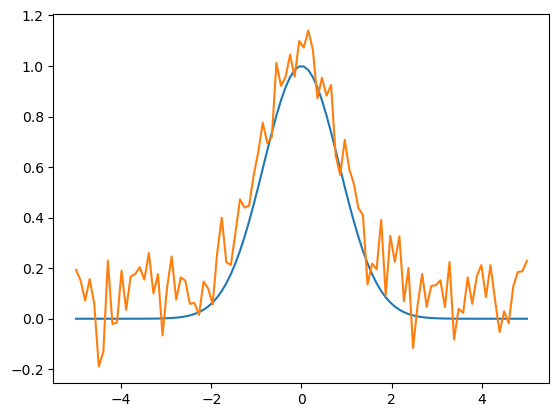

y-Amp*np.exp(-((x-Center)**2/(FWHM**2*np.sqrt(2))))


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [16]:
# Make a gausssian with default shape and position (height 1 at the origin, FWHM 1.
g = GaussianComponent2()

# Make a space in which we can plot the gaussian.
x = np.linspace(-5,5,100)
y = g.GetPlot(x)

# Make some "experimental data" which is just the default shape, noisy, and
# moved up the y axis a tad so the best fit will be different.
ynoise = y + np.random.normal(loc=0.1, scale=0.1, size=len(x))

# Draw it
plt.plot(x,y, x,ynoise)
plt.show()

# Do the fit (but this doesn't work...)
g.Fit(x,y)